In [16]:
import pandas as pd
import os
import streamlit as st
# gather all csv files in the folder
path = 'D:\Source_project\ETL_Pipeline_Tiki\data_crawl'
files = os.listdir(path)
files_list = [os.path.join(path, file) for file in files if file.endswith('.csv')]
all_dataframes = []
for file in files_list:
    df = pd.read_csv(file)
    all_dataframes.append(df)
data = pd.concat(all_dataframes, ignore_index=True)
df =data[['id',	'product_name',	'brand_name','original_price','price_after_voucher','discount_rate','discount_price','quantity_sold','rating_average','review_count','warranty_info','return_policy','date']].copy()


#convert 'quantity_sold' to 'quantity_sold_by_day'
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df = df.sort_values(by='date')
df['quantity_sold_by_day'] = df.groupby('id')['quantity_sold'].diff().fillna(0).astype(int)
df['quantity_sold_by_day']= df['quantity_sold_by_day'].apply(lambda x: 0 if x < 0 else x)
df['sale_by_day'] = df['quantity_sold_by_day'] * df['price_after_voucher']
df =df[['id',	'product_name',	'brand_name','original_price','price_after_voucher','discount_rate','discount_price','rating_average','review_count','warranty_info','return_policy','date','quantity_sold','quantity_sold_by_day',	'sale_by_day']].copy()


In [17]:
df =df[['id',	'product_name',	'brand_name','original_price','price_after_voucher','discount_rate','discount_price','rating_average','review_count','warranty_info','return_policy','date','quantity_sold','quantity_sold_by_day',	'sale_by_day']].copy()
df = df.loc[df['brand_name'] == 'Apple'].copy()


In [20]:
df.to_csv('D:\Source_project\ETL_Pipeline_Tiki\model.csv', index=False)

In [87]:
df1 = df[['id','product_name','brand_name']].drop_duplicates(ignore_index=True)
df2 = df.groupby('id').agg({'price_after_voucher':'mean','rating_average':'mean','quantity_sold_by_day':'sum','sale_by_day':'sum','discount_rate':'mean'}).reset_index()
df = df2.join(df1.set_index('id'),how='left', on='id')

In [90]:
df.head()

,id,price_after_voucher,rating_average,quantity_sold_by_day,sale_by_day,discount_rate,product_name,brand_name
0,4048043,329000.0,4.5,0,0,8.0,Điện Thoại Bàn Panasonic KX-TS500 - Hàng Chính...,Panasonic
1,4048581,689000.0,4.5,0,0,0.0,Điện Thoại Bàn Panasonic KX-TSC11 - Hàng Chính...,Panasonic
2,11251711,1920000.0,4.8,0,0,0.0,Điện thoại bàn không dây Panasonic KX-TGD312 -...,Panasonic
3,11251743,1260000.0,5.0,0,0,0.0,Điện thoại bàn không dây Panasonic KX-TGB112 -...,Panasonic
4,11251951,830000.0,4.1,0,0,0.0,Điện thoại bàn không dây Panasonic KX-TGB110-H...,Panasonic


In [89]:
df.to_csv('D:\Source_project\ETL_Pipeline_Tiki\data_gemini.csv',index=False)

Accuracy: 0.999259807549963
AUC-ROC: 0.9996193376475067


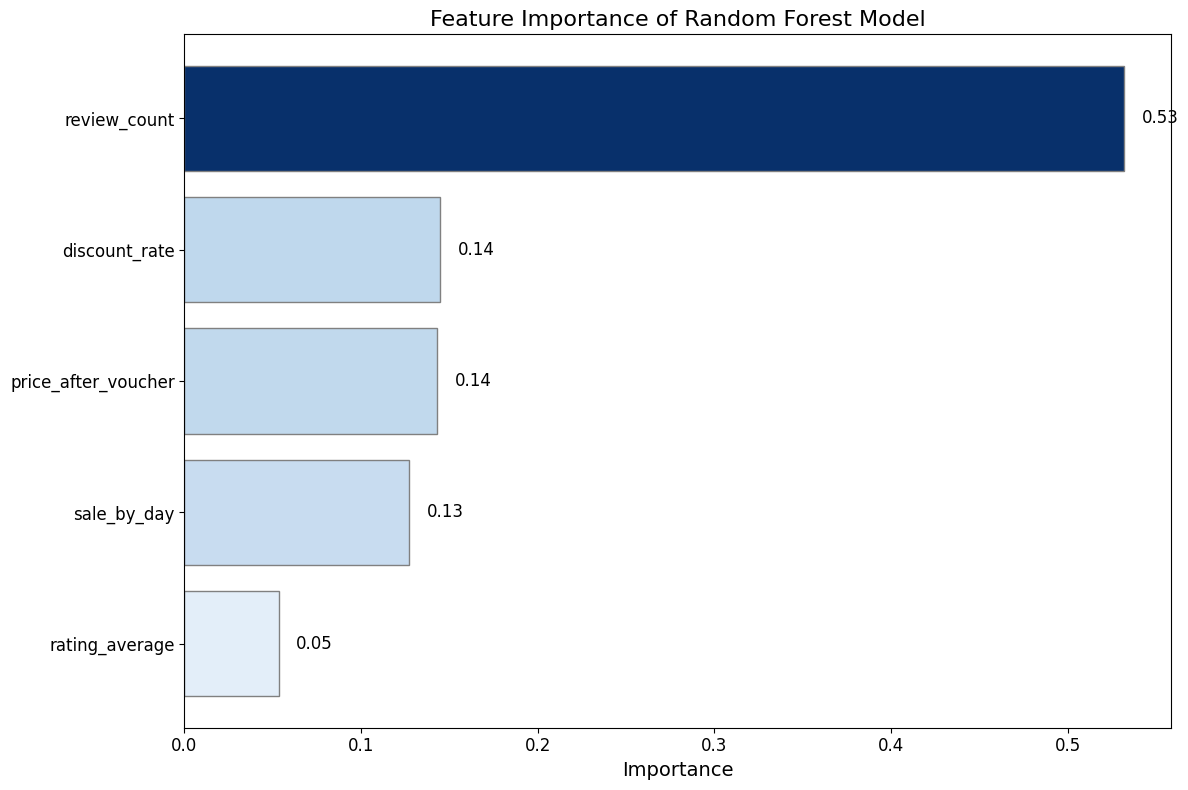

In [64]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score

# Đọc dữ liệu gốc
file_path = '/content/drive/MyDrive/Dataset/output.csv'
original_data = df

# Tạo cột "is_hot" dựa trên số lượng bán (quantity_sold)
threshold = 1000  # Ngưỡng để xác định sản phẩm "hot"
original_data['is_hot'] = original_data['quantity_sold'].apply(lambda x: 1 if x > threshold else 0)

# Chọn các cột đặc trưng và nhãn
X_class = original_data[['price_after_voucher', 'discount_rate', 'rating_average', 'review_count', 'sale_by_day']]
y_class = original_data['is_hot']

# Chia dữ liệu thành bộ huấn luyện và kiểm tra
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(X_class, y_class, test_size=0.2, random_state=42)



# Khởi tạo mô hình Random Forest
rf_model = RandomForestClassifier(random_state=42, n_estimators=100)

# Huấn luyện mô hình
rf_model.fit(X_train_class, y_train_class)

# Dự đoán trên bộ kiểm tra
y_pred_rf = rf_model.predict(X_test_class)

# Tính toán độ chính xác và AUC-ROC
accuracy_rf = accuracy_score(y_test_class, y_pred_rf)
roc_auc_rf = roc_auc_score(y_test_class, y_pred_rf)

# In kết quả
print(f'Accuracy: {accuracy_rf}')
print(f'AUC-ROC: {roc_auc_rf}')



import streamlit as st
import matplotlib.pyplot as plt
import pandas as pd

# Giả sử bạn đã huấn luyện mô hình RandomForest và có các dữ liệu X_class và rf_model
# Lấy độ quan trọng của các đặc trưng từ mô hình Random Forest
feature_importance = rf_model.feature_importances_

# Tạo dataframe để dễ dàng vẽ biểu đồ
features = X_class.columns
importance_df = pd.DataFrame({'feature': features, 'importance': feature_importance})

# Sắp xếp theo độ quan trọng giảm dần
importance_df = importance_df.sort_values(by='importance', ascending=False)

# Tạo một biểu đồ với các cải tiến đẹp mắt
plt.figure(figsize=(12, 8))

# Sử dụng một bảng màu để thể hiện độ quan trọng
bars = plt.barh(importance_df['feature'], importance_df['importance'], 
                color=plt.cm.Blues(importance_df['importance'] / max(importance_df['importance'])),
                edgecolor='grey')

# Thêm nhãn vào mỗi thanh
for bar in bars:
    plt.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height() / 2,
             f'{bar.get_width():.2f}', va='center', ha='left', fontsize=12, color='black')

# Tinh chỉnh nhãn trục x và trục y
plt.xlabel('Importance', fontsize=14)
plt.title('Feature Importance of Random Forest Model', fontsize=16)
plt.gca().invert_yaxis()  # Đảo ngược trục y để đặc trưng quan trọng nhất lên đầu

# Tinh chỉnh font chữ và không gian
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

# Hiển thị biểu đồ trong Streamlit
st.pyplot(plt)




In [65]:
# Nhóm dữ liệu theo ID sản phẩm và tính tổng số lượng bán cho mỗi sản phẩm
top_hot_products_grouped = original_data.groupby(['id', 'product_name', 'brand_name', 'price_after_voucher']).agg({
    'quantity_sold': 'sum',
    'rating_average': 'mean',
    'review_count': 'sum'
}).reset_index()

# Sắp xếp theo số lượng bán (quantity_sold) để lấy 5 sản phẩm "hot" nhất
top_hot_products_sorted_grouped = top_hot_products_grouped.sort_values(by='quantity_sold', ascending=False).head(5)

# Hiển thị chi tiết 5 sản phẩm hot nhất
top_hot_products_sorted_grouped[['id', 'product_name', 'brand_name', 'price_after_voucher', 'quantity_sold', 'rating_average', 'review_count']]


,id,product_name,brand_name,price_after_voucher,quantity_sold,rating_average,review_count
322,274037360,Điện Thoại POCO C65 (6GB/128GB) - Hàng Chính Hãng,POCO,2690000,477304,4.800000,1334
56,184036446,Apple iPhone 11,Apple,9890000,376120,4.800000,80149
324,274037365,Điện Thoại POCO C65 (8GB/256GB) - Hàng Chính Hãng,POCO,2990000,329658,4.822222,2117
172,270975124,Điện Thoại Oppo A58 6GB/128GB - Hàng Chính Hãng,OPPO,4090000,308396,5.000000,2629
59,184059211,Apple iPhone 13,Apple,13090000,210668,5.000000,54409


In [91]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
import joblib

df = pd.read_csv('D:\Source_project\ETL_Pipeline_Tiki\output.csv')


# Chọn các cột quan trọng và làm sạch dữ liệu
df_clean = df[['rating_average', 'price_after_voucher', 'review_count', 'quantity_sold', 'discount_rate']].dropna()

# Phân loại sản phẩm thành các nhóm
def classify_product(row):
    if row['rating_average'] >= 4.0 and row['price_after_voucher'] > 5000000:
        return 'Tốt'
    elif 2.5 <= row['rating_average'] < 4.0 and 2000000 <= row['price_after_voucher'] <= 5000000:
        return 'Trung bình'
    else:
        return 'Thấp'

df_clean['category'] = df_clean.apply(classify_product, axis=1)

# Bước 2: Chuẩn bị dữ liệu huấn luyện và kiểm tra
X = df_clean[['rating_average', 'price_after_voucher', 'review_count', 'quantity_sold', 'discount_rate']]
y = df_clean['category']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Chuẩn hóa dữ liệu
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Bước 3: Tìm giá trị k tối ưu
param_grid = {'n_neighbors': [3, 5, 7, 9, 11, 13]}
grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_scaled, y_train)

best_k = grid_search.best_params_['n_neighbors']
print(f'Giá trị k tối ưu: {best_k}')

# Bước 4: Huấn luyện mô hình KNN với k tối ưu
knn_final = KNeighborsClassifier(n_neighbors=best_k)
knn_final.fit(X_train_scaled, y_train)

# Đánh giá mô hình
y_pred = knn_final.predict(X_test_scaled)
print(classification_report(y_test, y_pred))

# Bước 5: Lưu mô hình
model_filename = 'D:\Source_project\ETL_Pipeline_Tiki\model\knn_final_model2.pkl'
joblib.dump(knn_final, model_filename)

# Kết quả: Đường dẫn lưu mô hình
print(f'Mô hình đã được lưu tại: {model_filename}')


Giá trị k tối ưu: 3
              precision    recall  f1-score   support

        Thấp       1.00      1.00      1.00      3467
  Trung bình       1.00      1.00      1.00        12
         Tốt       1.00      0.99      1.00       574

    accuracy                           1.00      4053
   macro avg       1.00      1.00      1.00      4053
weighted avg       1.00      1.00      1.00      4053

Mô hình đã được lưu tại: D:\Source_project\ETL_Pipeline_Tiki\model\knn_final_model2.pkl
